# Naive U-net with Pytorch

Simple code to run a baseline-like experiment with pytorch that includes:

 - Our own pytorch dataset class with the CARVANA dataset
 - Our own u-net like model
 - Our own loss-function

In [1]:
from torch.utils.data.dataset import Dataset
import os
from os.path import isfile, join
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn

%matplotlib inline

# Create pytorch dataset

In my case I previously splitted the training images and masks into a validation set with 10% of the training content. If you do nota have this splitting just set `subset='train'` or `subset='test'` when creating the dataset

In [2]:
class CARVANA(Dataset):
    """
        CARVANA dataset that contains car images as .jpg. Each car has 16 images
        taken in different angles and a unique id: id_01.jpg, id_02.jpg, ..., id_16.jpg
        The labels are provided as a .gif image that contains the manually cutout mask
        for each training image
    """

    def __init__(self, root, subset="train", transform=None):
        """

        :param root: it has to be a path to the folder that contains the dataset folders
        :param train: boolean true if you want the train set false for the test one
        :param transform: transform the images and labels
        """

        # initialize variables
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.subset = subset
        self.data_path, self.labels_path = [], []

        def load_images(path):
            """
            returns all the sorted image paths.

            :param path:
            :return: array with all the paths to the images
            """
            images_dir = [join(path, f) for f in os.listdir(path) if isfile(join(path, f))]
            images_dir.sort()

            return images_dir

        # load the data regarding the subset
        if self.subset == "train":
            self.data_path = load_images(self.root + "/train")
            self.labels_path = load_images(self.root + "/train_masks")
        elif self.subset == "val":
            self.data_path = load_images(self.root + "/val")
            self.labels_path = load_images(self.root + "/val_masks")
        elif self.subset == "test":
            self.data_path = load_images(self.root + "/test")
            self.labels_path = None
        else:
            raise RuntimeError('Invalid subset ' + self.subset + ', it must be one of:'
                                                                 ' \'train\', \'val\' or \'test\'')

    def __getitem__(self, index):
        """

        :param index:
        :return: tuple (img, target) with the input data and its label
        """

        # load image and labels
        img = Image.open(self.data_path[index])
        target = Image.open(self.labels_path[index]) if not self.subset == 'test' else None

        # apply transforms to both
        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)

        return img, target

    def __len__(self):
        return len(self.data_path)


## Check that the dataset was correctly created

We create a new objetc with our training set. Images and targets are scaled to 256*256.

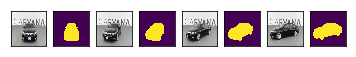

In [3]:
# create datasets
train_dataset = CARVANA(root='../data/',
                              subset="train",
                              transform=transforms.Compose([
                                  transforms.Scale((256,256)),
                                  transforms.ToTensor()])
                              )

# define the dataloader with the previous dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=8,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=1)

# define a simple function to show image-labels
def im_show(img_list):
    """
    It receives a list of images and plots them together
    :param img_list:
    :return:
    """
    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception("len(img_list) must be smaller than 10") 
        
    for idx, img in enumerate(img_list):
        img = np.array(to_PIL(img))
        plt.subplot(100 + 10 * len(img_list) + (idx + 1))
        fig = plt.imshow(img)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    
    plt.show()

img_list = []
for i in range(4):
    img, label = train_dataset[i]
    img_list.append(img)
    img_list.append(label)
    
im_show(img_list)
    

# Create the U-net model

Let's create a smal u-net like model as a toy example.

## Define the convolutional block

First we define the convolutional block so we do not need to re-write every time

In [4]:
class conv_block(nn.Module):
    """
    Define the convolutional - batch norm - relu block to avoid re-writing it
    every time
    """

    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size,
                              padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(out_size)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

## Define the network

Then we define the network keeping in mind that down_1 output size should match with the scaled output of up_2, while down_2 size should match with the scaled output of the middle convolution of the u-net model.

In [5]:
class small_UNET_256(nn.Module):
    """
    Define UNET model that accepts a 256 input and mostly uses 3x3 kernels
    with stride and padding = 1. It reduces the size of the image to 8x8 pixels
    ** It might not work if the input 'x' is not a square.
    """

    def __init__(self):
        super(small_UNET_256, self).__init__()

        self.down_1 = nn.Sequential(
            conv_block(3, 16),
            conv_block(16, 32, stride=2, padding=1))

        self.down_2 = nn.Sequential(
            conv_block(32, 64),
            conv_block(64, 128))

        self.middle = conv_block(128, 128, kernel_size=1, padding= 0)

        self.up_2 = nn.Sequential(
            conv_block(256, 128),
            conv_block(128, 32))

        self.up_0 = nn.Sequential(
            conv_block(64, 64),
            conv_block(64, 32))

        self.output = nn.Sequential(
            conv_block(32, 16),
            conv_block(16, 1, kernel_size=1, padding=0))

    def forward(self, x):
        # 256
        down1 = self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)

        # 64
        down2 = self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)

        # 8
        out = self.middle(out)

        # 64
        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)

        # 128
        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up_1(out)

        # 256
        out = F.upsample(out, scale_factor=2)
        return self.output(out)

## Create the loss function

Define the Binary Cross Entropy loss function

In [6]:
class BCELoss2d(nn.Module):
    """
    Code taken from:
    https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/37208
    """
    def __init__(self, weight=None, size_average=True):
        super(BCELoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)

    def forward(self, logits, targets):
        probs = F.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        return self.bce_loss(probs_flat, targets_flat)

# Create the training function

Set the model to train (batch norms, dropouts etc), set a progress bar and start to loop over the data.

Get the inputs and targets, compute the loss, propagate gradients and update the progress-bar with the results

In [7]:
# define the training function
def train(train_loader, model, criterion, epoch, num_epochs):
    model.train()

    # set a progress bar
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        # Convert torch tensor to Variable
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # compute output
        optimizer.zero_grad()
        outputs = model(images)

        # measure loss
        loss = criterion(outputs, labels)

        # compute gradient and do SGD step
        loss.backward()
        optimizer.step()

        # update progress bar status
        pbar.set_description('[TRAIN] - EPOCH %d/ %d - BATCH LOSS: %.4f(avg) '
                             % (epoch + 1, num_epochs, loss.data[0]))


# Run the training loop

Create the model, define the loss function and set-up the optimizer. Place everything in a for loop while calling the `train` function.

In [8]:
model = small_UNET_256().cuda()
criterion = BCELoss2d().cuda()
optimizer = optim.SGD(model.parameters(),
                      weight_decay=1e-4,
                      lr=1e-4,
                      momentum=0.9,
                      nesterov=True)

# run the training loop
num_epochs = 2
for epoch in range(0, num_epochs):
    # train for one epoch
    train(train_loader, model, criterion, epoch, num_epochs)

# Features to add

 - [ ] define the validation function
 - [ ] add a custom transform operation for data-augmentation
 - [ ] connect with tensorboard to log the experiments
 - [ ] store checkpoints while training
 - [ ] save output as a .csv ready to upload to the competition